## ETL y EDA sobre el dataset de steam_games para el Proyecto ML Ops de Henry

#### Describimos las variables que conforman el dataframe

* publisher: Empresa publicadora del contenido
* genres: Género del contenido
* app_name: Nombre del contenido
* title: Título del contenido
* url: URL de publicación del contenido
* release_date: Fecha de lanzamiento
* tags: Etiquetas de contenido
* discount_price: Precio de descuento
* reviews_url: Reviews de contenido
* specs: Especificaciones
* price: Precio del contenido
* early_access: Acceso temprano
* id: Identificador único de contenido
* developer: Desarrollador
* sentiment: Análisis de sentimientos
* metascore: Score por metacritic

#### Generación del primer Data Wrangling.

In [4]:
# Importación de las librerías necesarias
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Recuperación de los datos desde un archivo .json
dataset = []
with open('dataset/steam_games.json') as f:
    dataset.extend(ast.literal_eval(line) for line in f)
    
# Creación del dataframe a partir del dataset obtenido
data = pd.DataFrame(dataset)

In [6]:
# Verificamos la estructura de nuestro dataframe
data.shape

(32135, 16)

In [7]:
# Verificamos cómo está conformado
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24083 non-null  object 
 1   genres          28852 non-null  object 
 2   app_name        32133 non-null  object 
 3   title           30085 non-null  object 
 4   url             32135 non-null  object 
 5   release_date    30068 non-null  object 
 6   tags            31972 non-null  object 
 7   discount_price  225 non-null    float64
 8   reviews_url     32133 non-null  object 
 9   specs           31465 non-null  object 
 10  price           30758 non-null  object 
 11  early_access    32135 non-null  bool   
 12  id              32133 non-null  object 
 13  developer       28836 non-null  object 
 14  sentiment       24953 non-null  object 
 15  metascore       2677 non-null   object 
dtypes: bool(1), float64(1), object(14)
memory usage: 3.7+ MB


In [8]:
# Reubicación de la variable 'id' para un mejor conocimiento
cols = list(data.columns)
cols.remove('id')
cols = ['id'] + cols
data = data[cols]

In [9]:
# Verificamos si la variable 'id' contiene nulos
filas_null = data[data['id'].isna()]
filas_null

,id,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,developer,sentiment,metascore
74,NaN,NaN,NaN,NaN,NaN,http://store.steampowered.com/,NaN,NaN,14.99,NaN,NaN,19.99,False,NaN,NaN,NaN
30961,NaN,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...",NaN,NaN,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91


In [10]:
# Identificamos las filas duplicadas en la variable 'id'
filas_dup = data[data.duplicated('id', keep=False)]
filas_dup

,id,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,developer,sentiment,metascore
74,NaN,NaN,NaN,NaN,NaN,http://store.steampowered.com/,NaN,NaN,14.99,NaN,NaN,19.99,False,NaN,NaN,NaN
13894,612880,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...",NaN,http://steamcommunity.com/app/612880/reviews/?...,"[Single-player, Steam Achievements, Full contr...",59.99,False,Machine Games,Mostly Positive,86
14573,612880,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/Wolfe...,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...",NaN,http://steamcommunity.com/app/612880/reviews/?...,"[Single-player, Steam Achievements, Full contr...",59.99,False,Machine Games,Mostly Positive,86
30961,NaN,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...",NaN,NaN,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91


In [11]:
# Eliminamos las filas con nulos y duplicadas en la variable 'id'
data_con_valores_nuevos = data.copy()
data_con_valores_nuevos.drop([74, 14573], inplace=True)
data_con_valores_nuevos.reset_index(drop=True, inplace=True)

In [12]:
# Adecuamos del valor nulo en la variable 'id' en correlación a los demás valores existentes
filas_con_nulos = data_con_valores_nuevos[data_con_valores_nuevos['id'].isnull()].index
valores_no_nulos_ordenados = data_con_valores_nuevos.dropna(subset=['id']).sort_values('id')['id'].unique()
data_con_valores_nuevos.loc[filas_con_nulos, 'id'] = valores_no_nulos_ordenados[:len(filas_con_nulos)]

In [13]:
# Verificamos nuestro nuevo orden de variables y comprobamos la composición de nuestro dataframe
data_con_valores_nuevos

,id,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,developer,sentiment,metascore
0,761140,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,Kotoshiro,NaN,NaN
1,643980,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,Secret Level SRL,Mostly Positive,NaN
2,670290,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,Poolians.com,Mostly Positive,NaN
3,767400,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,彼岸领域,NaN,NaN
4,773570,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32128,773640,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.49,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,"Nikita ""Ghost_RUS""",NaN,NaN
32129,733530,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",4.24,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,Sacada,NaN,NaN
32130,610660,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",1.39,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,Laush Dmitriy Sergeevich,NaN,NaN
32131,658870,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",NaN,http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,"xropi,stev3ns",1 user reviews,NaN


In [14]:
# Normalizamos la variable 'release_date' para su consumo eficiente
data_steam = data_con_valores_nuevos.copy()
data_steam['release_date'] = pd.to_datetime(data_steam['release_date'], errors='coerce')
data_steam = data_steam.dropna(subset=['release_date'])
data_steam.reset_index(drop=True, inplace=True)

In [15]:
# Inspeccionamos la variable 'price', que más tarde usaremos en nuestro modelo predictor
data_steam['price'].unique()

array([4.99, 'Free To Play', 'Free to Play', 0.99, 3.99, 9.99, 18.99,
       29.99, nan, 10.99, 2.99, 1.59, 14.99, 1.99, 59.99, 8.99, 6.99,
       7.99, 39.99, 'Free', 19.99, 7.49, 12.99, 5.99, 2.49, 15.99, 1.25,
       24.99, 17.99, 61.99, 3.49, 11.99, 13.99, 'Free Demo',
       'Play for Free!', 34.99, 1.49, 32.99, 99.99, 14.95, 69.99, 16.99,
       79.99, 49.99, 5.0, 44.99, 13.98, 29.96, 119.99, 109.99, 149.99,
       771.71, 'Install Now', 21.99, 89.99,
       'Play WARMACHINE: Tactics Demo', 0.98, 139.92, 4.29, 64.99,
       'Free Mod', 54.99, 74.99, 'Install Theme', 0.89, 'Third-party',
       0.5, 'Play Now', 299.99, 1.29, 3.0, 15.0, 5.49, 23.99, 49.0, 20.99,
       10.93, 1.39, 'Free HITMAN™ Holiday Pack', 36.99, 4.49, 2.0, 4.0,
       234.99, 1.95, 1.5, 199.0, 189.0, 6.66, 27.99, 10.49, 129.99, 179.0,
       26.99, 399.99, 31.99, 399.0, 20.0, 40.0, 3.33, 22.99, 320.0, 38.85,
       71.7, 995.0, 27.49, 3.39, 6.0, 19.95, 499.99, 199.99, 16.06, 4.68,
       131.4, 44.98, 202.76, 

In [16]:
# Hacemos limpieza de la variable 'price'
steam_price = data_steam.copy()
reemplazar_valores = ['Free To Play', 'Free to Play', 'Free', 'Free Demo', 'Play for Free!', 'Free Mod',
                     'Free HITMAN™ Holiday Pack', 'Play the Demo', 'Free to Try', 'Free Movie', 'Free to Use', 
                     'Install Now', 'Play WARMACHINE: Tactics Demo', 'Install Theme', 'Third-party', 'Play Now']
steam_price['price'] = steam_price['price'].replace(reemplazar_valores, 0)
steam_price['price'] = steam_price['price'].replace(['Starting at $499.00'], '499.00')
steam_price['price'] = steam_price['price'].replace(['Starting at $449.00'], '449.00')
steam_price['price'] = steam_price['price'].fillna(0)
steam_price['price'] = steam_price['price'].astype(float)

In [17]:
# Limpiamos las restantes variables numéricas
steam_price['discount_price'] = steam_price['discount_price'].fillna(0)
steam_price['metascore'] = steam_price['metascore'].fillna(0)
steam_price['metascore'] = steam_price['metascore'].replace('NA', 0)

In [18]:
# Definimos una función para extraer los datos de las variables que contienen listas
def extraer_listas(df, columns_to_explode):
    data_exploded = df.copy()
    for column in columns_to_explode:
        data_exploded = data_exploded.explode(column)
    data_exploded.reset_index(drop=True, inplace=True)
    return data_exploded

In [19]:
# Seleccionamos y explotamos las variables de interés
col_listas = ['genres', 'tags', 'specs']
data_steam_final = extraer_listas(steam_price, col_listas)

In [20]:
# Mostramos el dataframe final
data_steam_final

,id,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,developer,sentiment,metascore
0,761140,Kotoshiro,Action,Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,Strategy,4.49,http://steamcommunity.com/app/761140/reviews/?...,Single-player,4.99,False,Kotoshiro,NaN,0
1,761140,Kotoshiro,Action,Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,Action,4.49,http://steamcommunity.com/app/761140/reviews/?...,Single-player,4.99,False,Kotoshiro,NaN,0
2,761140,Kotoshiro,Action,Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,Indie,4.49,http://steamcommunity.com/app/761140/reviews/?...,Single-player,4.99,False,Kotoshiro,NaN,0
3,761140,Kotoshiro,Action,Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,Casual,4.49,http://steamcommunity.com/app/761140/reviews/?...,Single-player,4.99,False,Kotoshiro,NaN,0
4,761140,Kotoshiro,Action,Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,Simulation,4.49,http://steamcommunity.com/app/761140/reviews/?...,Single-player,4.99,False,Kotoshiro,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991949,658870,SIXNAILS,Indie,EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,Atmospheric,0.00,http://steamcommunity.com/app/658870/reviews/?...,Steam Achievements,4.99,False,"xropi,stev3ns",1 user reviews,0
1991950,658870,SIXNAILS,Indie,EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,Atmospheric,0.00,http://steamcommunity.com/app/658870/reviews/?...,Steam Cloud,4.99,False,"xropi,stev3ns",1 user reviews,0
1991951,658870,SIXNAILS,Indie,EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,Relaxing,0.00,http://steamcommunity.com/app/658870/reviews/?...,Single-player,4.99,False,"xropi,stev3ns",1 user reviews,0
1991952,658870,SIXNAILS,Indie,EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,Relaxing,0.00,http://steamcommunity.com/app/658870/reviews/?...,Steam Achievements,4.99,False,"xropi,stev3ns",1 user reviews,0


#### Análisis de Componentes Principales (PCA).

In [21]:
# Importación de las librerías necesarias
import category_encoders as ce
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

In [22]:
# Codificamos las variables categóricas a numéricas para una mejor utilización del modelo
a_numérica = ce.OrdinalEncoder(cols=['id', 'publisher', 'genres', 'app_name', 'title', 'url', 'release_date',
       'tags', 'discount_price', 'reviews_url', 'specs', 'price',
       'early_access', 'developer', 'sentiment', 'metascore'])

# Definimos un dataframe para el cálculo del PCA 
data_steam_pca = a_numérica.fit_transform(data_steam_final)
data_steam_pca

,id,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,developer,sentiment,metascore
0,1,1,1,1,1,1,-1.0,1,1,1,1,1,1,1,19,1
1,1,1,1,1,1,1,-1.0,2,1,1,1,1,1,1,19,1
2,1,1,1,1,1,1,-1.0,3,1,1,1,1,1,1,19,1
3,1,1,1,1,1,1,-1.0,4,1,1,1,1,1,1,19,1
4,1,1,1,1,1,1,-1.0,5,1,1,1,1,1,1,19,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991949,29892,2585,3,29863,29863,29893,-1.0,45,2,29892,5,1,1,3683,3,1
1991950,29892,2585,3,29863,29863,29893,-1.0,45,2,29892,11,1,1,3683,3,1
1991951,29892,2585,3,29863,29863,29893,-1.0,226,2,29892,1,1,1,3683,3,1
1991952,29892,2585,3,29863,29863,29893,-1.0,226,2,29892,5,1,1,3683,3,1


In [23]:
# Entrenamos el modelo PCA con escalado de los datos y lo agrupamos en un pipeline
pipe_pca = make_pipeline(MinMaxScaler(), PCA())
pipe_pca.fit(data_steam_pca)
modelo_pca = pipe_pca.named_steps['pca']

[0.44669053 0.60215613 0.72843616 0.81168013 0.86131861 0.90954777
 0.95205606 0.97495783 0.99148071 0.99779675 0.99972148 0.99999992
 0.99999999 1.         1.         1.        ]


Text(0, 0.5, '% Varianza Acumulada')

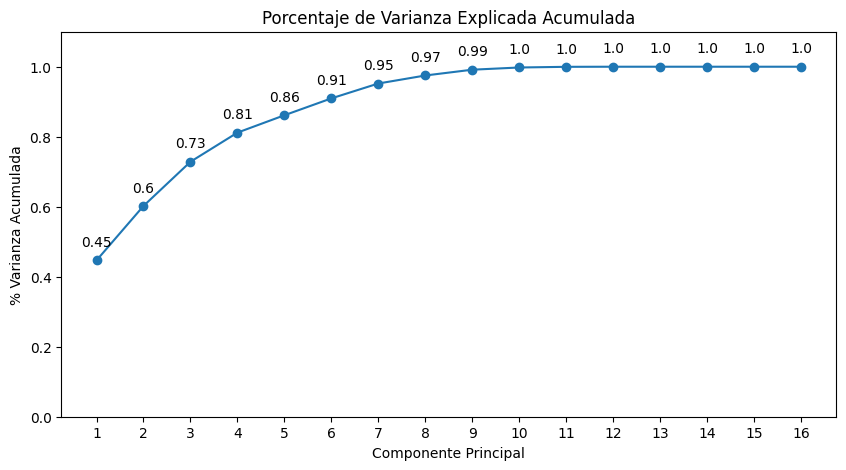

In [24]:
# Calculamos el porcentaje de varianza explicada acumulada
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print(prop_varianza_acum)

# Lo mostramos en un gráfico
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.plot(np.arange(len(data_steam_pca.columns)) + 1, prop_varianza_acum, marker = 'o')
for x, y in zip(np.arange(len(data_steam_pca.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center')
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de Varianza Explicada Acumulada')
ax.set_xlabel('Componente Principal')
ax.set_ylabel('% Varianza Acumulada')

In [25]:
# Definimos ahora un nuevo dataframe para mostrar el trabajo del PCA en columnas
pca_df = data_steam_pca
pca_df2 = pca_df
pca_df = MinMaxScaler().fit_transform(pca_df)
pca_df = pd.DataFrame(pca_df,columns=pca_df2.columns).set_index(pca_df2.index)
pca_df

,id,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,developer,sentiment,metascore
0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0
1,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.002967,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0
2,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.005935,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0
3,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.008902,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0
4,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.011869,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991949,1.0,0.317484,0.090909,0.999967,0.999967,1.0,0.0,0.130564,0.012821,0.999967,0.129032,0.0,0.0,0.338668,0.111111,0.0
1991950,1.0,0.317484,0.090909,0.999967,0.999967,1.0,0.0,0.130564,0.012821,0.999967,0.322581,0.0,0.0,0.338668,0.111111,0.0
1991951,1.0,0.317484,0.090909,0.999967,0.999967,1.0,0.0,0.667656,0.012821,0.999967,0.000000,0.0,0.0,0.338668,0.111111,0.0
1991952,1.0,0.317484,0.090909,0.999967,0.999967,1.0,0.0,0.667656,0.012821,0.999967,0.129032,0.0,0.0,0.338668,0.111111,0.0


In [26]:
# Procedemos a aplicar el PCA y calcular los porcentajes en las muestras explicadas anteriormente
pca = PCA(n_components=16)
principalComponents = pca.fit_transform(pca_df)
principalComp_Df = pd.DataFrame(data = principalComponents, columns = ['pca1','pca2','pca3','pca4','pca5','pca6','pca7','pca8','pca9','pca10','pca11','pca12','pca13','pca14','pca15','pca16']).set_index(pca_df.index)
print("Forma del dataframe de los Componentes Principales", principalComp_Df.shape)
explicacion = pca.explained_variance_ratio_
print(explicacion)
print('suma:', sum(explicacion[0:16]))

Forma del dataframe de los Componentes Principales (1991954, 16)
[4.46690534e-01 1.55465592e-01 1.26280033e-01 8.32439685e-02
 4.96384783e-02 4.82291604e-02 4.25082924e-02 2.29017705e-02
 1.65228816e-02 6.31603698e-03 1.92473340e-03 2.78441352e-04
 6.51672350e-08 1.25756224e-08 3.19319080e-33 1.23780167e-35]
suma: 0.9999999999999998


In [27]:
principalComp_Df

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16
0,-1.236611,0.227090,-0.507410,0.338388,0.183655,-0.245347,-0.083459,-0.138422,-0.017063,-0.048479,-0.016550,-0.000678,0.000005,-0.000001,-8.908256e-17,-6.982990e-18
1,-1.236595,0.226805,-0.507092,0.338176,0.185212,-0.243070,-0.084397,-0.138682,-0.017207,-0.048520,-0.016551,-0.000681,0.000005,-0.000001,-2.759538e-17,-2.695520e-18
2,-1.236579,0.226520,-0.506774,0.337963,0.186770,-0.240794,-0.085335,-0.138942,-0.017351,-0.048560,-0.016552,-0.000683,0.000005,-0.000001,-5.593965e-17,-3.353504e-18
3,-1.236563,0.226236,-0.506456,0.337751,0.188327,-0.238517,-0.086273,-0.139202,-0.017495,-0.048601,-0.016553,-0.000686,0.000005,-0.000001,7.804181e-14,7.173901e-16
4,-1.236547,0.225951,-0.506138,0.337538,0.189884,-0.236241,-0.087211,-0.139463,-0.017639,-0.048641,-0.016554,-0.000688,0.000005,-0.000001,-1.606073e-19,-1.193768e-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991949,1.046464,-0.442528,-0.142197,-0.007969,-0.108662,-0.064821,-0.110232,-0.052228,-0.100078,-0.062777,-0.006708,-0.000627,-0.000008,0.000022,5.121131e-21,5.172938e-21
1991950,1.046764,-0.438118,-0.139097,-0.005128,-0.158004,0.033265,0.048600,-0.063747,-0.102267,-0.064537,-0.006423,-0.000579,-0.000008,0.000022,3.559234e-20,7.786138e-21
1991951,1.049138,-0.496972,-0.086732,-0.048344,0.206129,0.281837,-0.385872,-0.091622,-0.124704,-0.068938,-0.007113,-0.001103,-0.000008,0.000021,1.274942e-20,5.813626e-21
1991952,1.049337,-0.494033,-0.084666,-0.046450,0.173234,0.347227,-0.279984,-0.099302,-0.126163,-0.070111,-0.006923,-0.001071,-0.000008,0.000021,3.306357e-20,7.555759e-21


In [28]:
steam_eda_reduc = data_steam_final.drop(['id', 'publisher', 'app_name', 'url', 'discount_price', 'reviews_url', 'sentiment'], axis=1, inplace=True)
steam_eda_reduc = data_steam_final[data_steam_final['price'] != 0]
steam_eda_reduc.reset_index(drop=True, inplace=True)
steam_eda_reduc.columns

Index(['genres', 'title', 'release_date', 'tags', 'specs', 'price',
       'early_access', 'developer', 'metascore'],
      dtype='object')

In [29]:
steam_eda_reduc = steam_eda_reduc.dropna(subset=['genres'])
steam_eda_reduc['genres'] = steam_eda_reduc['genres'].replace('Design &amp; Illustration', 'Design & Illustration').replace('Animation &amp; Modeling', 'Animation & Modeling')
steam_eda_reduc['genres'].value_counts()

Indie                    413033
Action                   326486
Adventure                216788
Casual                   167565
Strategy                 164105
RPG                      145957
Simulation               138049
Early Access              43768
Sports                    36777
Racing                    28562
Free to Play              27475
Massively Multiplayer     25956
Design & Illustration      3430
Utilities                  2749
Web Publishing             2118
Animation & Modeling       1953
Education                  1472
Software Training          1127
Video Production            634
Photo Editing               593
Audio Production            369
Accounting                   25
Name: genres, dtype: int64

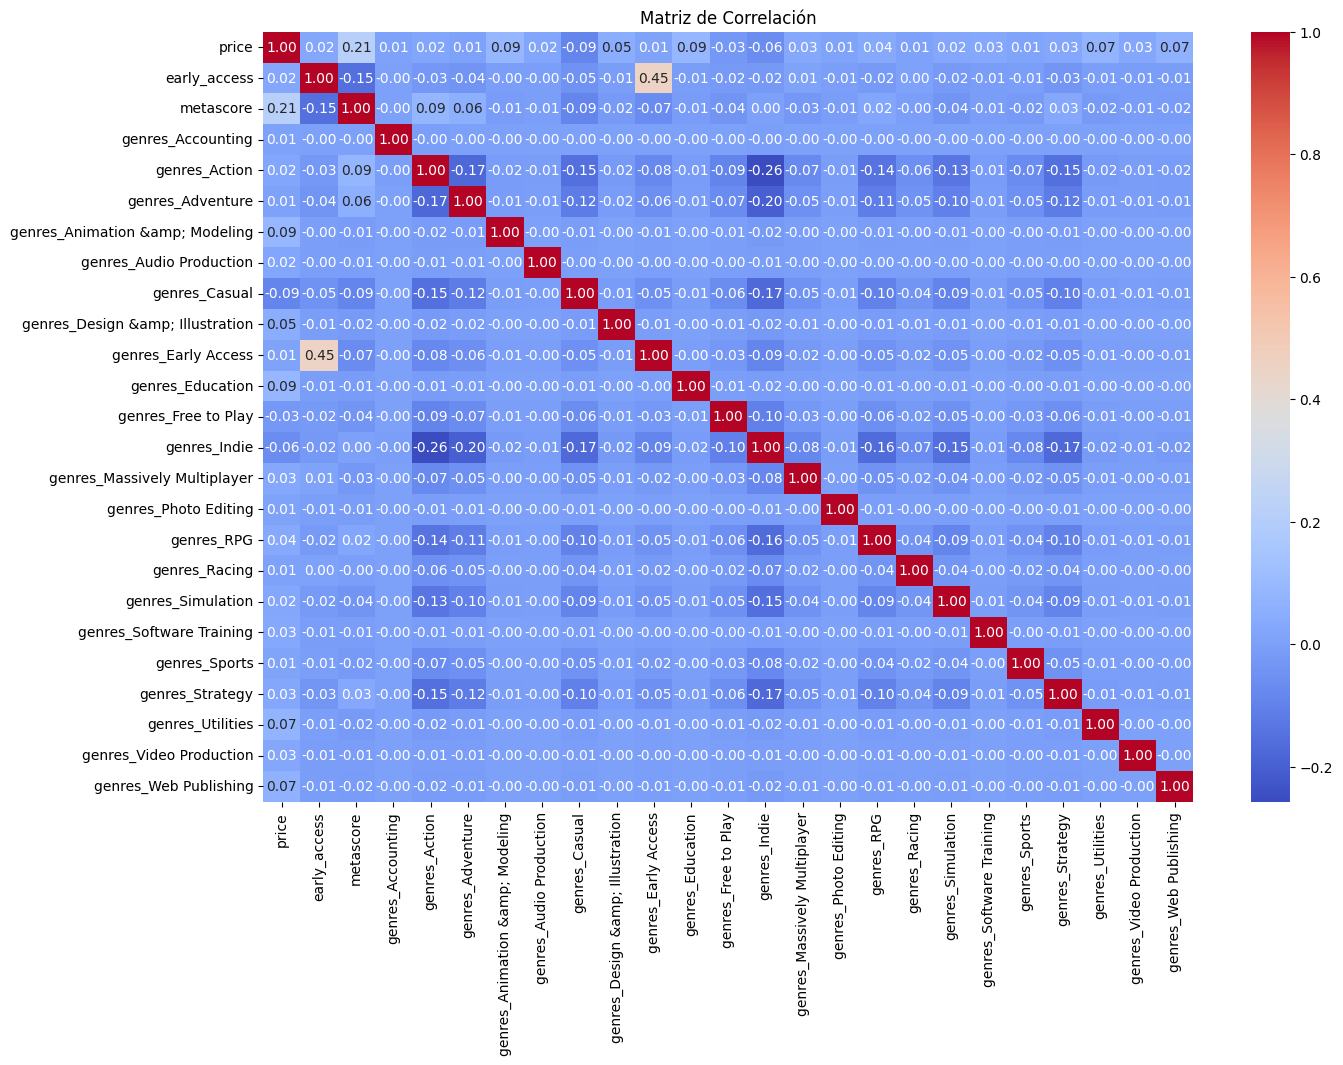

In [31]:
data_steam_copy = data_steam_final.copy()

# Codificar las variables categóricas utilizando one-hot encoding
data_steam_copy = pd.get_dummies(data_steam_copy, columns=['genres'])

# Calcular la matriz de correlación
correlation_matrix = data_steam_copy.corr()

# Crear la visualización de la matriz de correlación
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

In [32]:
# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Generar el histograma con la función histplot de Seaborn
sns.histplot(steam_eda['price'], bins=100, kde=False, color='blue')

# Obtener el mínimo y máximo precio
min_price = steam_eda['price'].min()
max_price = steam_eda['price'].max()

# Configurar etiquetas y título
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.title('Histograma del Precio de los Videojuegos')

# Mostrar los resultados estadísticos
plt.text(0.75, 0.9, f"Media: {steam_eda['price'].mean():.2f}\nMediana: {steam_eda['price'].median():.2f}\nDesviación Estándar: {steam_eda['price'].std():.2f}",
         transform=plt.gca().transAxes)

# Agregar líneas verticales para mostrar el mínimo y máximo precio
plt.axvline(min_price, color='red', linestyle='dashed', linewidth=2, label=f'Mínimo: {min_price:.2f}')
plt.axvline(max_price, color='green', linestyle='dashed', linewidth=2, label=f'Máximo: {max_price:.2f}')

# Mostrar la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

NameError: name 'steam_eda' is not defined

In [ ]:
# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Ordenar el dataframe por precio mínimo en orden ascendente y seleccionar los 10 primeros
top_min_prices = steam_eda.nsmallest(10, 'price')

# Ordenar el dataframe por precio máximo en orden descendente y seleccionar los 10 primeros
top_max_prices = steam_eda.nlargest(10, 'price')

# Crear el gráfico de barras para el top 10 de precios mínimos utilizando Seaborn
plt.figure(figsize=(10, 5))
sns.barplot(x='title', y='price', data=top_min_prices, color='red')
plt.xlabel('Juego')
plt.ylabel('Precio Mínimo')
plt.title('Top 10 de Precios Mínimos de Juegos')
plt.xticks(rotation=90)
plt.show()

# Crear el gráfico de barras para el top 10 de precios máximos utilizando Seaborn
plt.figure(figsize=(10, 5))
sns.barplot(x='title', y='price', data=top_max_prices, color='green')
plt.xlabel('Juego')
plt.ylabel('Precio Máximo')
plt.title('Top 10 de Precios Máximos de Juegos')
plt.xticks(rotation=90)
plt.show()

In [33]:
pd.crosstab(index=data_steam_final['genres'], columns=data_steam_final['early_access'])

early_access,False,True
genres,,
Accounting,29,0
Action,331624,34489
Adventure,217971,19273
Animation &amp; Modeling,2084,148
Audio Production,411,14
Casual,171462,12338
Design &amp; Illustration,3540,182
Early Access,0,50579
Education,1549,59


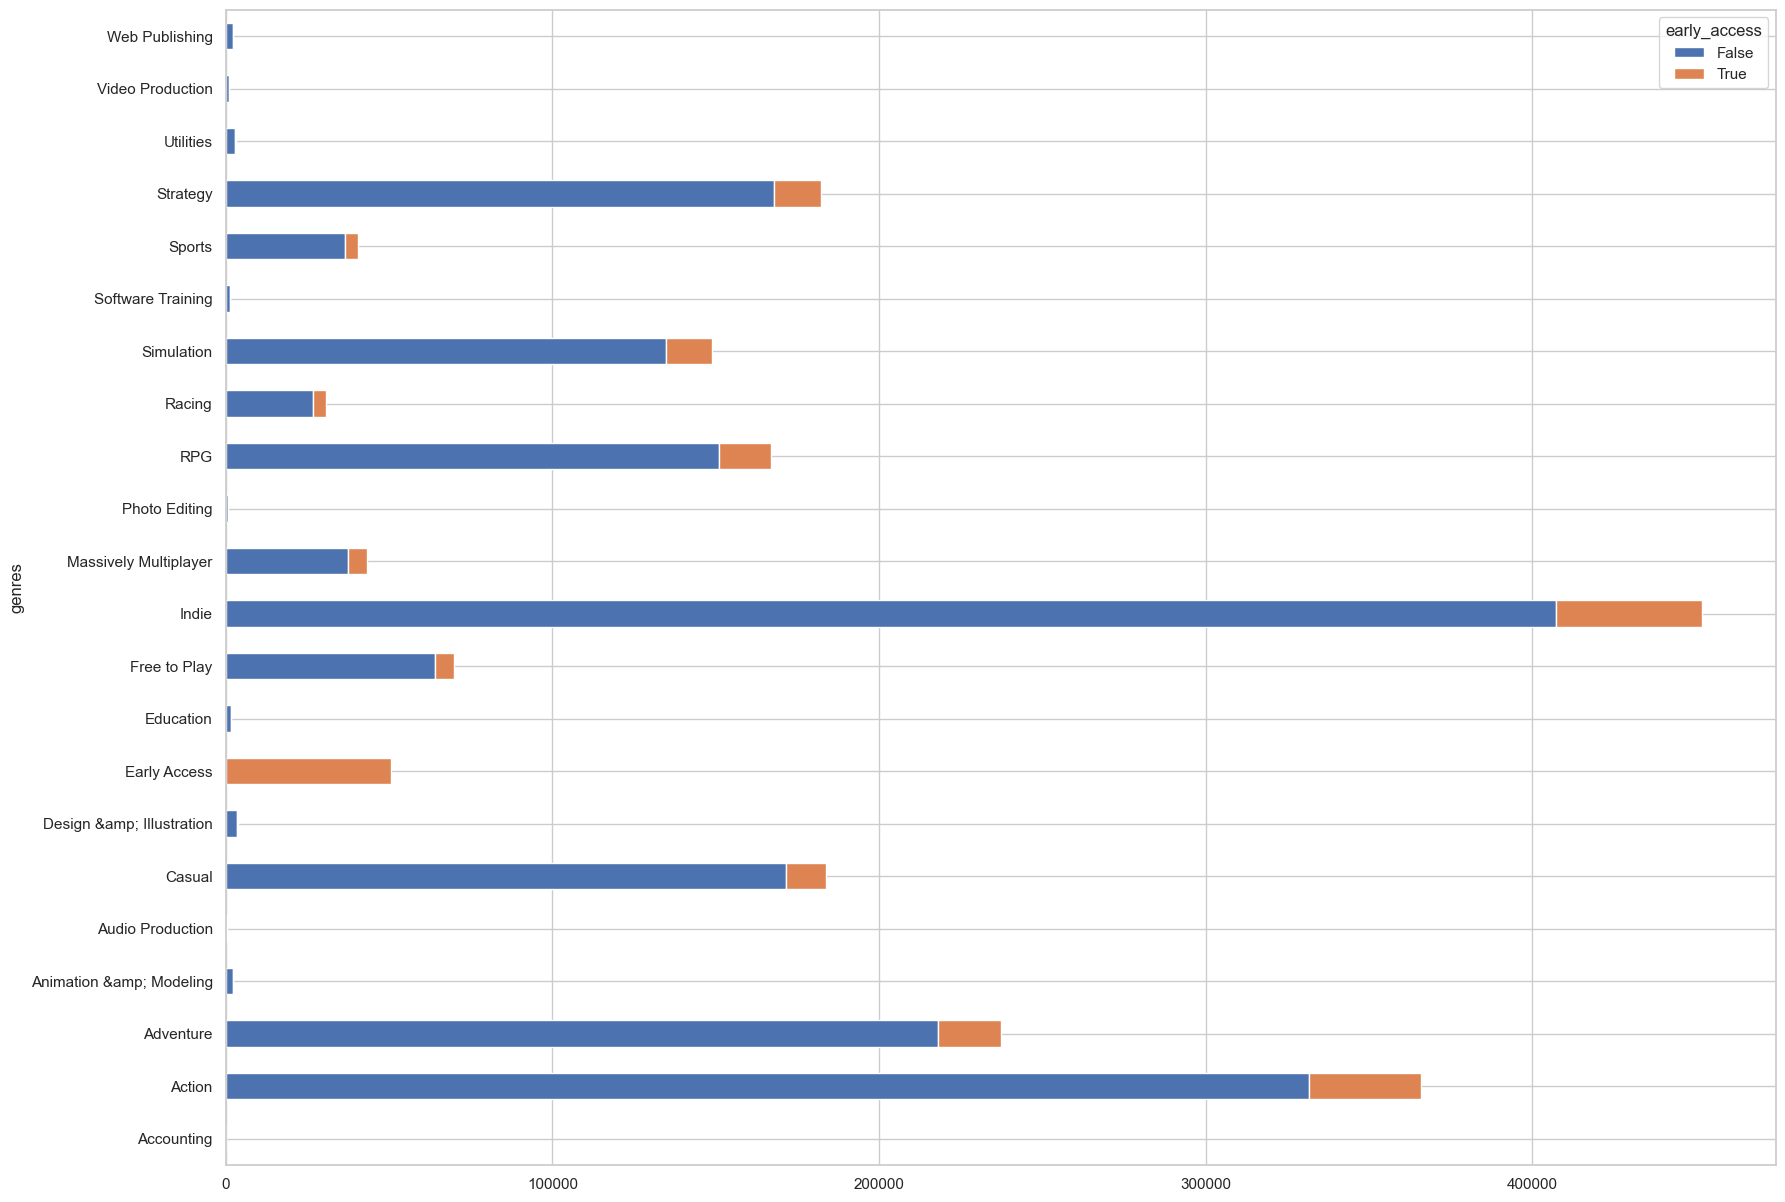

In [34]:
pd.crosstab(index=data_steam_final['genres'], columns=data_steam_final['early_access']).plot.barh(stacked=True,
                                                                            figsize=(20, 15))
plt.show()

<Figure size 1200x1200 with 0 Axes>

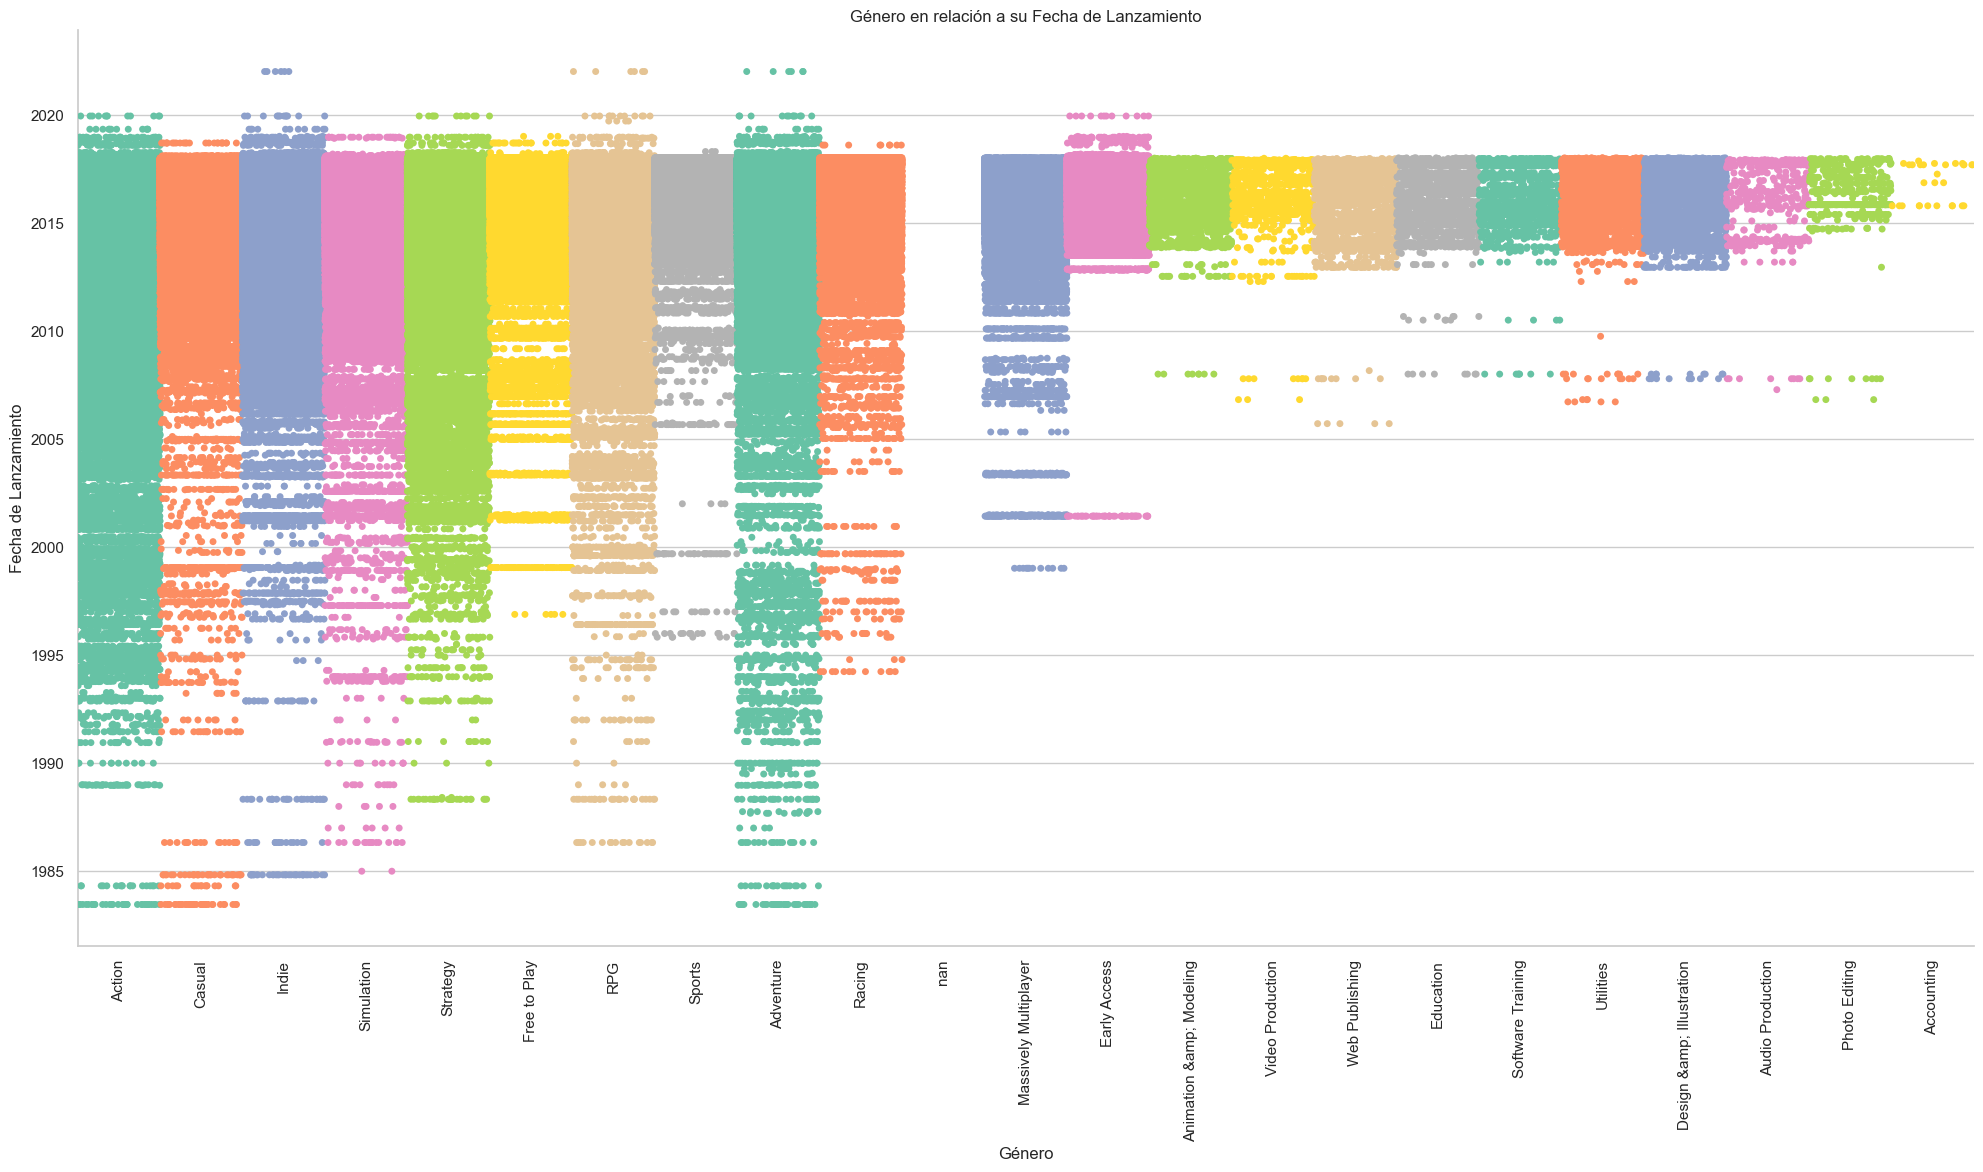

In [35]:
# Convertir los datos de la columna 'release_date' al tipo de datos datetime (omitir si ya están en formato datetime)
data_steam_final['release_date'] = pd.to_datetime(data_steam_final['release_date'])

# Crear el catplot usando Seaborn
plt.figure(figsize=(12, 12))
sns.catplot(x='genres', y='release_date', data=data_steam_final, jitter=0.5, hue='genres', palette='Set2', height=10, aspect=2)
plt.xticks(rotation=90)
plt.xlabel('Género')
plt.ylabel('Fecha de Lanzamiento')
plt.title('Género en relación a su Fecha de Lanzamiento')
plt.show()

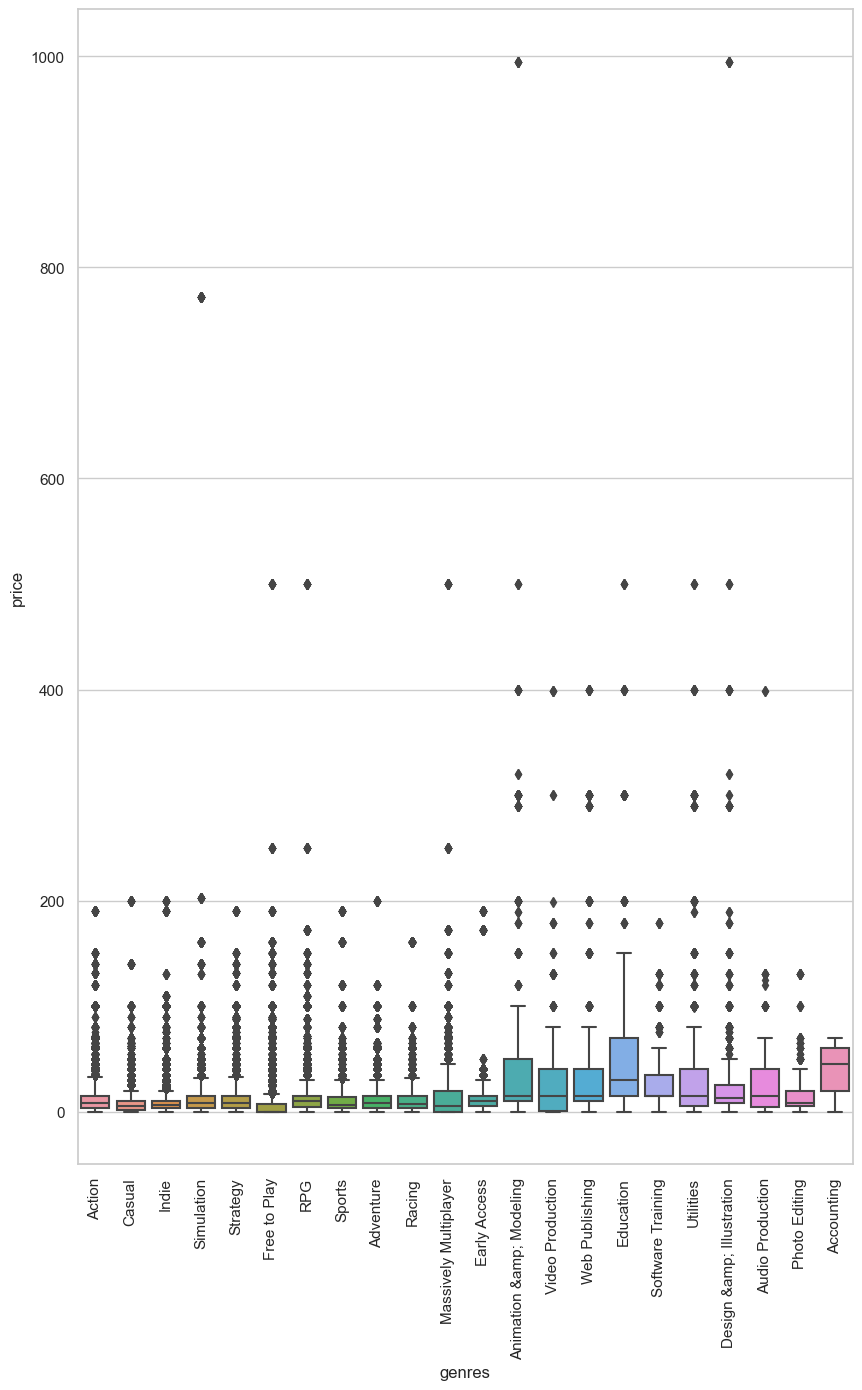

In [36]:
# Usamos un tipo de gráfico boxplot para mostrar los resultados del 'describe' 
plt.figure(figsize=(10, 15))
sns.boxplot(data=data_steam_final, x='genres', y='price')
plt.xticks(rotation=90)
plt.show()

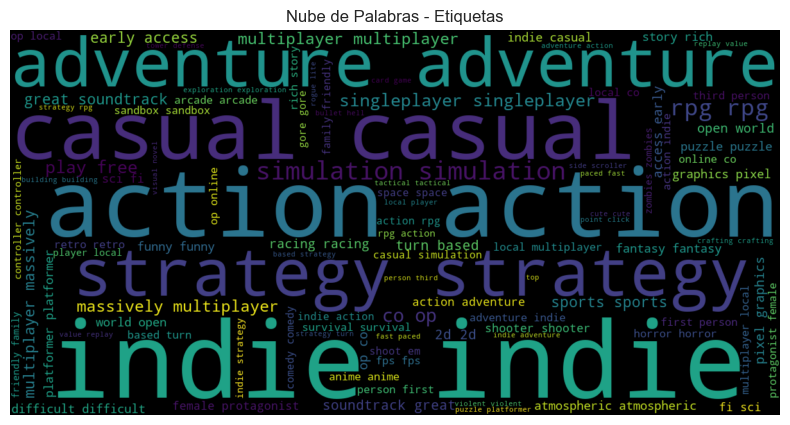

In [45]:
# Copiar el dataframe original para trabajar con una copia y no modificar los datos originales
data_steam_copy = data_steam_final.copy()

# Convertir la columna 'tags' al tipo de datos string si es necesario (omitir si ya es string)
data_steam_copy['tags'] = data_steam_copy['tags'].astype(str)

# Combine todas las etiquetas en un solo texto
all_tags = ' '.join(data_steam_copy['tags']).lower()

# Crear el objeto WordCloud con las configuraciones deseadas
wordcloud = WordCloud(width=1200, height=600, background_color='black', colormap='viridis', max_words=100).generate(all_tags)

# Visualizar el gráfico de nubes de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - Etiquetas')
plt.show()

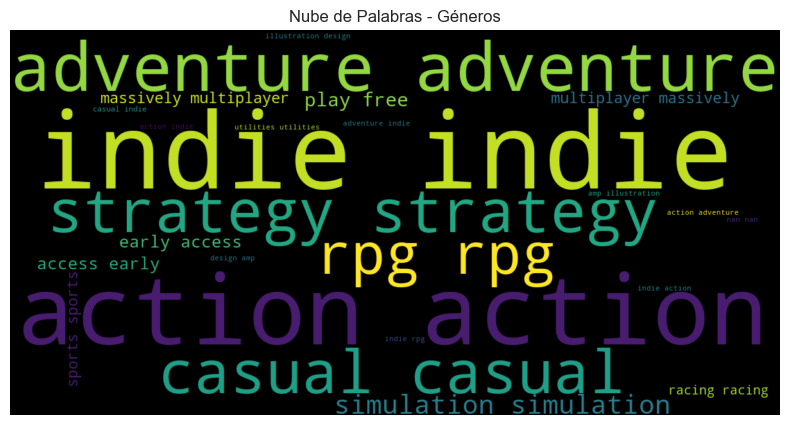

In [44]:
# Convertir la columna 'tags' al tipo de datos string si es necesario (omitir si ya es string)
data_steam_copy['genres'] = data_steam_copy['genres'].astype(str)

# Combine todas las etiquetas en un solo texto
all_tags = ' '.join(data_steam_copy['genres']).lower()

# Crear el objeto WordCloud con las configuraciones deseadas
wordcloud = WordCloud(width=1200, height=600, background_color='black', colormap='viridis', max_words=25).generate(all_tags)

# Visualizar el gráfico de nubes de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - Géneros')
plt.show()